# Particle Feynman Benchmark (infodynamics_jax, no GPyTorch)

This notebook replaces the original Torch/GPyTorch implementation with a pure infodynamics_jax workflow:
- Annealed SMC with HMC rejuvenation
- Type-II (VFE) baseline
- Predictive comparison and ESS diagnostics


In [1]:
import os
import sys
from pathlib import Path

os.environ.setdefault('JAX_PLATFORMS', 'cpu')

cwd = Path(os.getcwd())
repo_root = cwd
while repo_root.parent != repo_root:
    if (repo_root / 'infodynamics_jax').exists():
        break
    repo_root = repo_root.parent

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

examples_dir = repo_root / 'examples'
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels import rbf
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.gp.predict import predict_typeii
from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.energy import InertialEnergy, InertialCFG
from infodynamics_jax.inference.particle import AnnealedSMC, AnnealedSMCCFG
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective

from utils import synthetic, compute_metrics, setup_plot_style, COLORS, plot_with_uncertainty

matplotlib.use('module://matplotlib_inline.backend_inline')
jax.config.update('jax_enable_x64', True)

setup_plot_style()


## Config


In [3]:
class CFG:
    N_train = 120
    N_test = 60
    noise_std = 0.2
    domain = (-2.5, 2.5)
    M = 20
    n_particles = 64
    n_steps = 24
    ess_threshold = 0.6
    rejuvenation = 'hmc'
    rejuvenation_steps = 2
    step_size = 0.02
    n_leapfrog = 8
    bma_samples = 80
    typeii_steps = 300
    typeii_lr = 1e-2

cfg = CFG()


## Data (one function)


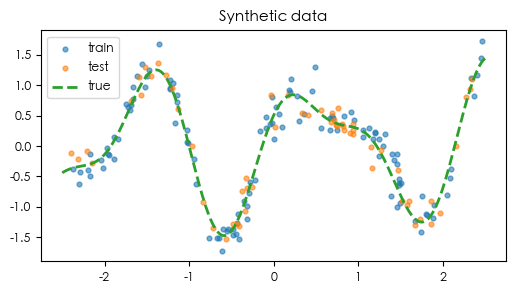

In [4]:
key = jax.random.key(0)
fn, title, desc, category = synthetic.get('sine_mix')

key, subkey = jax.random.split(key)
X_all, Y_all, _ = synthetic.sample(
    'sine_mix',
    N=cfg.N_train + cfg.N_test,
    noise=cfg.noise_std,
    domain=cfg.domain,
    key=subkey,
)
X_all = X_all[:, None]

key, subkey = jax.random.split(key)
perm = jax.random.permutation(subkey, X_all.shape[0])
train_idx = perm[:cfg.N_train]
test_idx = perm[cfg.N_train:]

X_train = X_all[train_idx]
Y_train = Y_all[train_idx]
X_test = X_all[test_idx]
Y_test = Y_all[test_idx]

X_plot = jnp.linspace(cfg.domain[0], cfg.domain[1], 240)[:, None]
Y_plot = fn(X_plot[:, 0])

plt.figure(figsize=(6, 3))
plt.scatter(np.array(X_train[:, 0]), np.array(Y_train), s=12, alpha=0.6, color=COLORS['train'], label='train')
plt.scatter(np.array(X_test[:, 0]), np.array(Y_test), s=12, alpha=0.6, color=COLORS['test'], label='test')
plt.plot(np.array(X_plot[:, 0]), np.array(Y_plot), color=COLORS['true'], lw=2, ls='--', label='true')
plt.title('Synthetic data')
plt.legend()
plt.show()


## Phi + Energy


In [5]:
Z = jnp.linspace(cfg.domain[0], cfg.domain[1], cfg.M)[:, None]
phi_init = Phi(
    kernel_params=KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0)),
    Z=Z,
    likelihood_params={'noise_var': jnp.array(cfg.noise_std**2)},
    jitter=1e-6,
)

gaussian_likelihood = get_likelihood('gaussian')
energy = InertialEnergy(
    kernel_fn=rbf,
    likelihood=gaussian_likelihood,
    cfg=InertialCFG(estimator='analytic', gh_n=20, inner_steps=0),
    residual='fitc',
)


## Annealed SMC (Array-only, fully JIT-compiled)

**關鍵優化：使用純 array 表示 + lax.scan，完全避免 Python object 和 Python loop，讓 JAX 可以真正 JIT 編譯整個 SMC**


## Array-only SMC (fast path)

We run annealed SMC on a *pure array state* `theta = [log_ell, log_sf2, log_sn2, Z_flat]`.
This avoids Python objects (Phi/KernelParams) inside the SMC loop, so `lax.scan` + JIT can fully compile.
Prediction later converts a sampled `theta` back to `Phi` for plotting.


開始運行 SMC（第一次會編譯，請稍候）...
SMC 完成！耗時: 1.05 秒


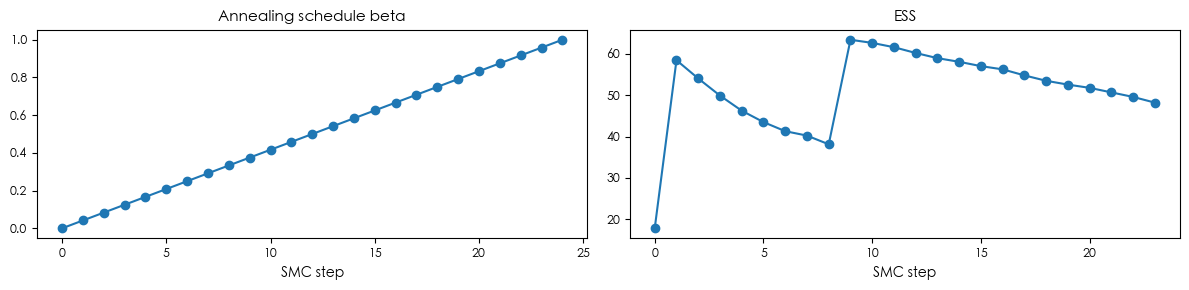

In [6]:
# ============================================================================
# Array-only SMC: 完全避免 Python object，使用 lax.scan 實現真正 JIT
# ============================================================================

from utils.smc_array_only import annealed_smc_array
from infodynamics_jax.gp.sparsify import fitc_log_evidence

Z0 = phi_init.Z

def unpack_state(theta):
    """將 array 解包"""
    log_ell, log_sf2, log_sn2 = theta[0], theta[1], theta[2]
    Z = theta[3:].reshape(Z0.shape)
    return log_ell, log_sf2, log_sn2, Z

def theta_to_phi(theta):
    """將 theta array 轉換為 Phi 對象"""
    log_ell, log_sf2, log_sn2, Z = unpack_state(theta)
    return Phi(
        kernel_params=KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2)),
        Z=Z,
        likelihood_params={'noise_var': jnp.exp(log_sn2)},
        jitter=phi_init.jitter,
    )

def energy_theta(theta):
    """純 array 版本的 energy（綁定 X, Y）"""
    log_ell, log_sf2, log_sn2, Z = unpack_state(theta)
    params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
    noise_var = jnp.exp(log_sn2)
    return -fitc_log_evidence(
        kernel_fn=rbf,
        params=params,
        X=X_train,
        y=Y_train,
        Z=Z,
        noise_var=noise_var,
        jitter=phi_init.jitter,
    )

def init_particles_array(key, n_particles):
    """初始化 particles（純 array）"""
    key_l, key_v, key_n, key_z = jax.random.split(key, 4)
    log_ell = jnp.log(phi_init.kernel_params.lengthscale) + jax.random.normal(key_l, (n_particles,)) * 0.5
    log_sf2 = jnp.log(phi_init.kernel_params.variance) + jax.random.normal(key_v, (n_particles,)) * 0.5
    log_sn2 = jnp.log(phi_init.likelihood_params['noise_var']) + jax.random.normal(key_n, (n_particles,)) * 0.5
    Z_noisy = Z0[None, :, :] + 0.2 * jax.random.normal(key_z, (n_particles, *Z0.shape))
    return jnp.concatenate(
        [log_ell[:, None], log_sf2[:, None], log_sn2[:, None], Z_noisy.reshape(n_particles, -1)],
        axis=1,
    )

def compute_bma_predictions(particles, logw, X_star, k_top=10):
    """計算 BMA 預測（加權混合）"""
    logw_norm = logw - jax.scipy.special.logsumexp(logw)
    w = jnp.exp(logw_norm)
    k_top = int(jnp.minimum(k_top, w.shape[0]))
    idx = jnp.argsort(w)[-k_top:]
    w_sub = w[idx] / jnp.sum(w[idx])
    
    mus, vars_ = [], []
    for i in idx.tolist():
        phi_i = theta_to_phi(particles[int(i)])
        mu_i, var_i = predict_typeii(phi_i, X_star, X_train, Y_train, rbf, residual='fitc')
        mus.append(mu_i)
        vars_.append(var_i)
    
    mus = jnp.stack(mus)
    vars_ = jnp.maximum(jnp.stack(vars_), 1e-12)
    mean = (w_sub[:, None] * mus).sum(axis=0)
    second = (w_sub[:, None] * (vars_ + mus**2)).sum(axis=0)
    var = jnp.maximum(second - mean**2, 1e-12)
    return mean, jnp.sqrt(var), w_sub, idx

# JIT 整個 SMC
smc_jit = jax.jit(
    lambda key, init_p: annealed_smc_array(
        key=key,
        init_particles=init_p,
        energy_fn=energy_theta,
        n_steps=cfg.n_steps,
        ess_threshold=cfg.ess_threshold,
        step_size=cfg.step_size,
        n_leapfrog=cfg.n_leapfrog,
        rejuvenation_steps=cfg.rejuvenation_steps,
    )
)

# 運行 SMC
key, subkey = jax.random.split(key)
init_particles = init_particles_array(subkey, cfg.n_particles)

print("開始運行 SMC（第一次會編譯，請稍候）...")
import time
t0 = time.time()
smc_result_array = smc_jit(key, init_particles)
t1 = time.time()
print(f"SMC 完成！耗時: {t1-t0:.2f} 秒")

# 包裝結果以兼容後續代碼
class SMCRun:
    def __init__(self, result_dict):
        self.particles = result_dict['particles']
        self.logw = result_dict['logw']
        self.ess_trace = result_dict['ess_trace']
        self.logZ_est = result_dict['logZ_est']
        self.betas = result_dict['betas']

smc_result = SMCRun(smc_result_array)

# 診斷圖
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(np.array(smc_result.betas), marker='o')
axes[0].set_title('Annealing schedule beta')
axes[0].set_xlabel('SMC step')
axes[1].plot(np.array(smc_result.ess_trace), marker='o')
axes[1].set_title('ESS')
axes[1].set_xlabel('SMC step')
plt.tight_layout()
plt.show()


## Type-II baseline

**ML-II (Maximum Likelihood Type-II)**: Optimizes VFE objective
- Objective: `phi* = argmin_phi VFE(phi)`
- VFE = NLL(y; 0, Q + σ²I) + (1/(2σ²)) * tr(K_ff - Q_ff)
- Uses `make_vfe_objective()` which computes the collapsed VFE for Gaussian likelihood


In [7]:
# ML-II: Optimize VFE objective (no hyperprior)
# VFE = NLL(y; 0, Q + σ²I) + (1/(2σ²)) * tr(K_ff - Q_ff)
vfe_objective = make_vfe_objective(kernel_fn=rbf, residual='fitc')
typeii_cfg = TypeIICFG(steps=cfg.typeii_steps, lr=cfg.typeii_lr, optimizer='adam', jit=True, constrain_params=True)
typeii = TypeII(cfg=typeii_cfg)
phi_mlii = typeii.run(energy=vfe_objective, phi_init=phi_init, energy_args=(X_train, Y_train)).phi


## Predictive comparison


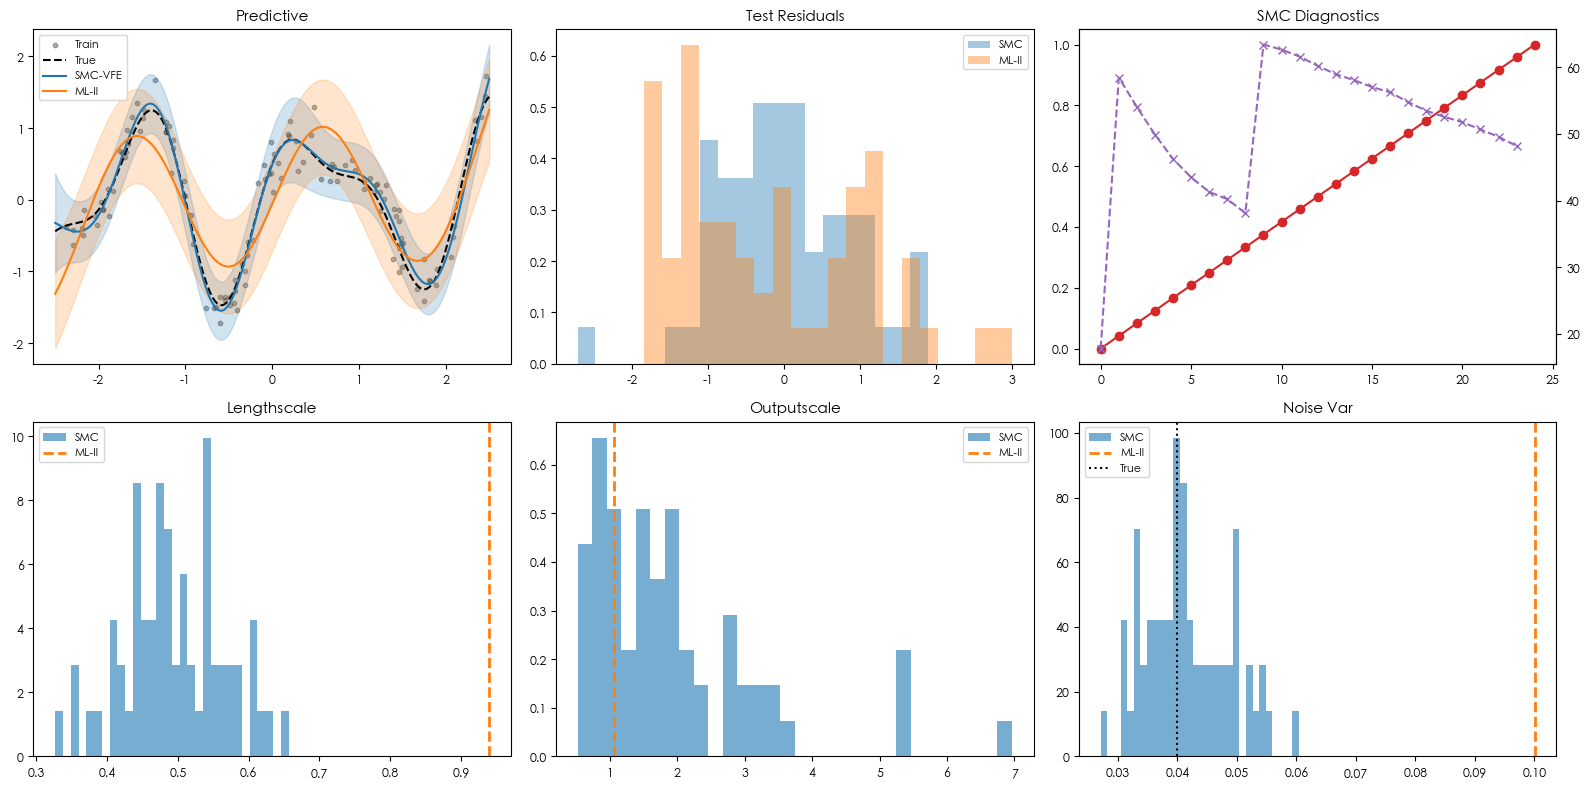

In [8]:
# 計算預測
smc_mean, smc_std, w_sub, idx = compute_bma_predictions(smc_result.particles, smc_result.logw, X_plot)
smc_mean_test, smc_std_test, _, _ = compute_bma_predictions(smc_result.particles, smc_result.logw, X_test)

mlii_mean, mlii_var = predict_typeii(phi_mlii, X_plot, X_train, Y_train, rbf, residual='fitc')
mlii_std = jnp.sqrt(mlii_var)
mlii_mean_test, mlii_var_test = predict_typeii(phi_mlii, X_test, X_train, Y_train, rbf, residual='fitc')
mlii_std_test = jnp.sqrt(mlii_var_test)

# 計算殘差
Y_test_flat = Y_test.squeeze() if Y_test.ndim > 1 else Y_test
smc_resid = np.array(((Y_test_flat - smc_mean_test) / smc_std_test).flatten())
mlii_resid = np.array(((Y_test_flat - mlii_mean_test) / mlii_std_test).flatten())

# 提取參數用於直方圖
theta_all = smc_result.particles
ls_samples = np.array(jnp.exp(theta_all[:, 0]))
sf2_samples = np.array(jnp.exp(theta_all[:, 1]))
sn2_samples = np.array(jnp.exp(theta_all[:, 2]))

mlii_ls = float(phi_mlii.kernel_params.lengthscale)
mlii_sf2 = float(phi_mlii.kernel_params.variance)
mlii_sn2 = float(phi_mlii.likelihood_params['noise_var'])

# 綜合繪圖
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
ax_pred, ax_resid, ax_ess, ax_ls, ax_sf2, ax_sn2 = axes.flat

# 1. Predictive
ax_pred.scatter(np.array(X_train[:, 0]), np.array(Y_train), s=10, alpha=0.3, c='k', label='Train')
ax_pred.plot(np.array(X_plot[:, 0]), np.array(Y_plot), 'k--', label='True')
m, s = np.array(smc_mean), np.array(smc_std)
ax_pred.plot(np.array(X_plot[:, 0]), m, 'C0', label='SMC-VFE')
ax_pred.fill_between(np.array(X_plot[:, 0]).flatten(), m-2*s, m+2*s, color='C0', alpha=0.2)
m, s = np.array(mlii_mean), np.array(mlii_std)
ax_pred.plot(np.array(X_plot[:, 0]), m, 'C1', label='ML-II')
ax_pred.fill_between(np.array(X_plot[:, 0]).flatten(), m-2*s, m+2*s, color='C1', alpha=0.2)
ax_pred.legend(fontsize=8)
ax_pred.set_title("Predictive")

# 2. Residuals
ax_resid.hist(smc_resid, bins=20, density=True, alpha=0.4, color='C0', label='SMC')
ax_resid.hist(mlii_resid, bins=20, density=True, alpha=0.4, color='C1', label='ML-II')
ax_resid.legend(fontsize=8)
ax_resid.set_title("Test Residuals")

# 3. ESS / Beta
ax_ess.plot(np.array(smc_result.betas), 'o-', color='C3', label='Beta')
ax2 = ax_ess.twinx()
ax2.plot(np.array(smc_result.ess_trace), 'x--', color='C4', label='ESS')
ax_ess.set_title("SMC Diagnostics")

# 4,5,6 Hyperparameters
for p_key, ax, title, samples, mlii_val in [
    ('ls', ax_ls, 'Lengthscale', ls_samples, mlii_ls),
    ('sf2', ax_sf2, 'Outputscale', sf2_samples, mlii_sf2),
    ('sn2', ax_sn2, 'Noise Var', sn2_samples, mlii_sn2)
]:
    ax.hist(samples, bins=30, density=True, alpha=0.6, color='C0', label='SMC')
    ax.axvline(mlii_val, color='C1', lw=2, ls='--', label='ML-II')
    if p_key == 'sn2':
        ax.axvline(float(cfg.noise_std**2), color='k', ls=':', label='True')
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


## Metrics


In [9]:
# Metrics (SMC mixture vs ML-II)
# 使用已計算的預測結果
logw_norm = smc_result.logw - jax.scipy.special.logsumexp(smc_result.logw)
logw_sub = logw_norm[idx]

# 計算各 component 的預測（用於 NLPD）
mus_nlpd, vars_nlpd = [], []
for i in idx.tolist():
    phi_i = theta_to_phi(smc_result.particles[int(i)])
    mu_i, var_i = predict_typeii(phi_i, X_test, X_train, Y_train, rbf, residual='fitc')
    mus_nlpd.append(mu_i)
    vars_nlpd.append(var_i)

mus_nlpd = jnp.stack(mus_nlpd)
vars_nlpd = jnp.maximum(jnp.stack(vars_nlpd), 1e-12)

# Mixture NLPD: log-sum-exp over components
y = Y_test
log_pdf = -0.5 * (jnp.log(2 * jnp.pi * vars_nlpd) + (y[None, :] - mus_nlpd) ** 2 / vars_nlpd)
smc_nlpd = -jnp.mean(jax.scipy.special.logsumexp(logw_sub[:, None] + log_pdf, axis=0))

smc_metrics = compute_metrics(Y_test, smc_mean_test, smc_std_test)
smc_metrics['nlpd'] = float(smc_nlpd)
mlii_metrics = compute_metrics(Y_test, mlii_mean_test, mlii_std_test)

print('SMC:', smc_metrics)
print('ML-II:', mlii_metrics)
print(f"NLPD 差異 (SMC - ML-II): {smc_metrics['nlpd'] - mlii_metrics['nlpd']:.4f}")

SMC: {'rmse': 0.18707001226060901, 'mae': 0.14802921879928774, 'r2': 0.9471312012894865, 'nlpd': 0.8976960767029772, 'coverage': 98.33334350585938}
ML-II: {'rmse': 0.4183676919934681, 'mae': 0.365558303351172, 'r2': 0.735572041870939, 'nlpd': 0.6032266240324129, 'coverage': 96.66667175292969}
NLPD 差異 (SMC - ML-II): 0.2945


對照：True Mixture vs Gaussian Approximation
測試點 y = -0.2797
  Mixture NLPD (正確):  0.7086
  Gaussian NLPD (錯誤): -0.4344
  差異: -1.1430
Mixture mean: -0.4169, std: 0.2078


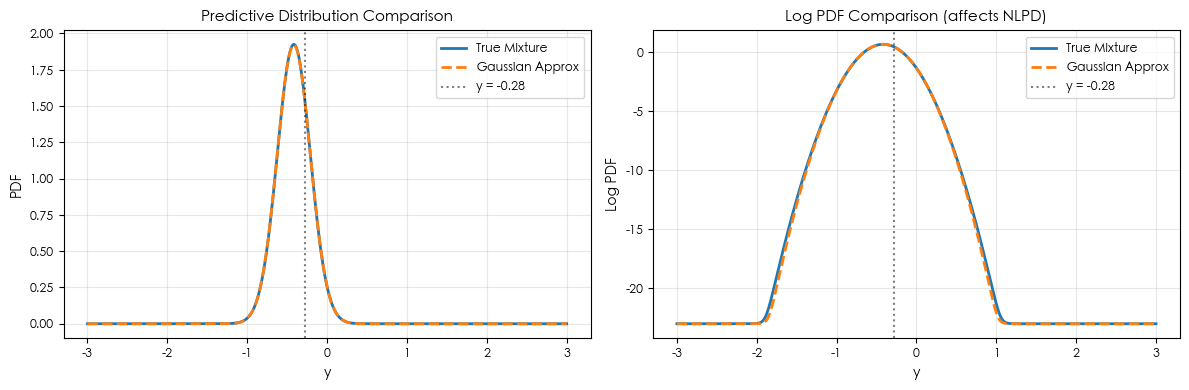


💡 關鍵洞察：Mixture 的 predictive distribution 通常是 multi-modal 的，
   Gaussian approximation 會忽略這些模式，導致 NLPD 被高估。
   這就是為什麼要用 log-sum-exp 來正確計算 mixture 的 NLPD。


In [10]:
# ============================================================================
# 📊 對照：True Mixture vs Gaussian Approximation 的 NLPD 差異
# ============================================================================
# 這展示了為什麼不能用「壓成 Gaussian」的方式來計算 BMA 的 NLPD

def normal_logpdf_demo(y, mu, var):
    """計算單個 Gaussian 的 log PDF"""
    return -0.5 * (jnp.log(2 * jnp.pi * var) + (y - mu)**2 / var)

# 選擇一個測試點來展示
test_idx_demo = 0
y_demo = Y_test[test_idx_demo]

# 使用已計算的預測結果
mus_demo = mus_nlpd[:, test_idx_demo]
vars_demo = vars_nlpd[:, test_idx_demo]

# 方法 1：正確的 mixture NLPD
logp_mixture = jax.scipy.special.logsumexp(
    logw_sub + normal_logpdf_demo(y_demo, mus_demo, vars_demo)
)
nlpd_mixture = -logp_mixture

# 方法 2：錯誤的 Gaussian approximation NLPD
mean_gauss = (w_sub * mus_demo).sum()
second_gauss = (w_sub * (vars_demo + mus_demo**2)).sum()
var_gauss = second_gauss - mean_gauss**2
logp_gauss = normal_logpdf_demo(y_demo, mean_gauss, var_gauss)
nlpd_gauss = -logp_gauss

print("=" * 70)
print("對照：True Mixture vs Gaussian Approximation")
print("=" * 70)
print(f"測試點 y = {y_demo:.4f}")
print(f"  Mixture NLPD (正確):  {nlpd_mixture:.4f}")
print(f"  Gaussian NLPD (錯誤): {nlpd_gauss:.4f}")
print(f"  差異: {nlpd_gauss - nlpd_mixture:.4f}")
print(f"Mixture mean: {mean_gauss:.4f}, std: {jnp.sqrt(var_gauss):.4f}")
print("=" * 70)

# 繪製 predictive distribution 的比較
from scipy import stats

y_grid = np.linspace(-3, 3, 500)
pdf_mixture = np.zeros_like(y_grid)
for i in range(len(w_sub)):
    pdf_mixture += float(w_sub[i]) * stats.norm.pdf(y_grid, float(mus_demo[i]), float(jnp.sqrt(vars_demo[i])))
pdf_gauss = stats.norm.pdf(y_grid, float(mean_gauss), float(jnp.sqrt(var_gauss)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(y_grid, pdf_mixture, 'C0', lw=2, label='True Mixture')
axes[0].plot(y_grid, pdf_gauss, 'C1', lw=2, ls='--', label='Gaussian Approx')
axes[0].axvline(y_demo, color='k', linestyle=':', alpha=0.5, label=f'y = {y_demo:.2f}')
axes[0].set_xlabel('y')
axes[0].set_ylabel('PDF')
axes[0].set_title('Predictive Distribution Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

logpdf_mixture = np.log(pdf_mixture + 1e-10)
logpdf_gauss = np.log(pdf_gauss + 1e-10)
axes[1].plot(y_grid, logpdf_mixture, 'C0', lw=2, label='True Mixture')
axes[1].plot(y_grid, logpdf_gauss, 'C1', lw=2, ls='--', label='Gaussian Approx')
axes[1].axvline(y_demo, color='k', linestyle=':', alpha=0.5, label=f'y = {y_demo:.2f}')
axes[1].set_xlabel('y')
axes[1].set_ylabel('Log PDF')
axes[1].set_title('Log PDF Comparison (affects NLPD)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 關鍵洞察：Mixture 的 predictive distribution 通常是 multi-modal 的，")
print("   Gaussian approximation 會忽略這些模式，導致 NLPD 被高估。")
print("   這就是為什麼要用 log-sum-exp 來正確計算 mixture 的 NLPD。")

In [11]:
## 診斷：SMC vs ML-II 參數比較

particles = smc_result.particles
w = jnp.exp(smc_result.logw - jax.scipy.special.logsumexp(smc_result.logw))

log_ells, log_sf2s, log_sn2s = particles[:, 0], particles[:, 1], particles[:, 2]
mlii_log_ell = jnp.log(phi_mlii.kernel_params.lengthscale)
mlii_log_sf2 = jnp.log(phi_mlii.kernel_params.variance)
mlii_log_sn2 = jnp.log(phi_mlii.likelihood_params['noise_var'])

w_mean_log_ell = (w * log_ells).sum()
w_mean_log_sf2 = (w * log_sf2s).sum()
w_mean_log_sn2 = (w * log_sn2s).sum()

print("參數比較:")
print(f"  SMC 加權平均 log(lengthscale): {w_mean_log_ell:.4f} vs ML-II: {mlii_log_ell:.4f}")
print(f"  SMC 加權平均 log(variance): {w_mean_log_sf2:.4f} vs ML-II: {mlii_log_sf2:.4f}")
print(f"  SMC 加權平均 log(noise_var): {w_mean_log_sn2:.4f} vs ML-II: {mlii_log_sn2:.4f}")
print(f"\n權重熵: {-jnp.sum(w * jnp.log(w + 1e-10)):.4f} (越大越分散)")

參數比較:
  SMC 加權平均 log(lengthscale): -0.6971 vs ML-II: -0.0619
  SMC 加權平均 log(variance): 0.5520 vs ML-II: 0.0583
  SMC 加權平均 log(noise_var): -3.2155 vs ML-II: -2.3020

權重熵: 4.0130 (越大越分散)


In [12]:
## 診斷：Variance 分解

# 對所有 particles 計算預測
w = jnp.exp(smc_result.logw - jax.scipy.special.logsumexp(smc_result.logw))
mus_all, vars_all = [], []
for i in range(smc_result.particles.shape[0]):
    phi_i = theta_to_phi(smc_result.particles[i])
    mu_i, var_i = predict_typeii(phi_i, X_test, X_train, Y_train, rbf, residual='fitc')
    mus_all.append(mu_i)
    vars_all.append(var_i)

mus_all = jnp.stack(mus_all)
vars_all = jnp.stack(vars_all)

# Variance 分解
smc_mean_all = (w[:, None] * mus_all).sum(axis=0)
weighted_var = (w[:, None] * vars_all).sum(axis=0)  # E[Var_i]
mean_variance = (w[:, None] * (mus_all - smc_mean_all[None, :])**2).sum(axis=0)  # Var[E_i]
total_var = weighted_var + mean_variance

print("Variance 分解（測試集）:")
print(f"  來自各 particles 的 uncertainty (E[Var_i]): {weighted_var.mean():.6f}")
print(f"  來自 mean 差異的 uncertainty (Var[E_i]): {mean_variance.mean():.6f}")
print(f"  總 variance: {total_var.mean():.6f}, std: {jnp.sqrt(total_var).mean():.6f}")
print(f"  ML-II variance: {mlii_var_test.mean():.6f}, std: {mlii_std_test.mean():.6f}")

Variance 分解（測試集）:
  來自各 particles 的 uncertainty (E[Var_i]): 0.049082
  來自 mean 差異的 uncertainty (Var[E_i]): 0.000103
  總 variance: 0.049184, std: 0.221506
  ML-II variance: 0.109758, std: 0.331252


In [13]:

w = w / jnp.sum(w)

# predictions for all particles (or a subset)
mus = []
vars_ = []
for i in range(smc_result.particles.shape[0]):
    phi_i = theta_to_phi(smc_result.particles[i])
    mu_i, var_i = predict_typeii(phi_i, X_plot, X_train, Y_train, rbf, residual="fitc")
    mus.append(mu_i)
    vars_.append(var_i)

mus = jnp.stack(mus)      # [P, N*]
vars_ = jnp.stack(vars_)  # [P, N*]

# weighted mixture moments
mean = (w[:, None] * mus).sum(axis=0)
second = (w[:, None] * (vars_ + mus**2)).sum(axis=0)
std = jnp.sqrt(jnp.maximum(second - mean**2, 1e-12))
